In [1]:
%load_ext autoreload
%autoreload 2
%pdb
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)

Automatic pdb calling has been turned ON


In [2]:
import sys
#sys.path.insert(0, '/home/ubuntu/Documents/infembed/infembed')
sys.path.insert(0, '/home/ubuntu/Documents/infembed/infembed')
sys.path.insert(0, '/home/ubuntu/Documents/infembed/data')
from data._core.spotcheck import get_spotcheck_dataloader, get_blindspots_df
sys.path.insert(0, '/home/ubuntu/Documents/infembed/models')
#sys.path.insert(0, '/home/ubuntu/Documents/infembed/')
# sys.path.insert(0, )
from infembed.embedder._core.fast_kfac_embedder import FastKFACEmbedder
import torchvision
from torch.utils.data import Subset, DataLoader, default_collate, Dataset
from torchvision.models import ResNet18_Weights, resnet18
import torch.nn as nn
from infembed.clusterer._core.sklearn_clusterer import SklearnClusterer
from infembed.clusterer._core.rule_clusterer import RuleClusterer
from sklearn.cluster import KMeans
from tqdm import tqdm
import pandas as pd
import torch
from typing import List
from infembed.utils.common import Data
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable
from torch import Tensor
from typing import Tuple
from models._utils.common import init_linear
from lightning.pytorch.callbacks import EarlyStopping
import lightning.pytorch as pl
import lightning as L
import torch.nn.functional as F
import numpy as np

### figure out device to compute embeddings on ###

In [3]:
DEVICE = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print('device:', DEVICE)

device: cuda:1


### define data
We will define the following:
- `eval_dataloader`: `DataLoader` for evaluation data.  This is used to compute embeddings for the evaluation data
- `eval_dataset`: `Dataset` for evaluation data.  This is used to retrieve individual examples for displaying.
- `train_dataloader`: `DataLoader` for training data.  This is needed to know how to compute embeddings for the evaluation data

In [4]:
normalize = ResNet18_Weights.IMAGENET1K_V1.transforms()

def collate_fn(examples):
    return tuple([_x.to(device=DEVICE) for _x in default_collate([(normalize(__x[0]), __x[1]) for __x in examples])])

BATCH_SIZE = 32
NUM_EVAL = 5000
eval_dataset = Subset(
    torchvision.datasets.ImageNet("/home/ubuntu/Documents/infembed/data/files/imagenet", split="val"),
    range(NUM_EVAL),
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE)

_train_data = torchvision.datasets.ImageNet("/home/ubuntu/Documents/infembed/data/files/imagenet", split="val")
NUM_TRAIN = 5000
train_data = Subset(_train_data, torch.randperm(len(_train_data))[:NUM_TRAIN])
train_dataloader = DataLoader(train_data, collate_fn=collate_fn, batch_size=BATCH_SIZE)

### define model ###

In [5]:
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device=DEVICE)
# model.load_state_dict(ResNet18_Weights.IMAGENET1K_V1.get_state_dict(progress=True))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### define embedder ###

In [6]:
layers = [
    "fc",
    "layer4.0.conv1",
    "layer4.0.conv2",
    "layer4.0.downsample.0",
    "layer4.1.conv1",
    "layer4.1.conv2",
]

embedder = FastKFACEmbedder(
    model=model,
    layers=layers,
    loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    sample_wise_grads_per_batch=True,
    projection_dim=50,
    projection_on_cpu=True,
    show_progress=True,
    per_layer_blocks=1,
)

### compute eigenvalues of Hessian ###

In [7]:
_, _, eigvals = embedder._retrieve_projections_fast_kfac_embedder_helper(
    train_dataloader,
    True,
    True,
    None,
    None,
    True,
)

INFO:root:compute training data statistics
processing `hessian_dataset` batch:   0%|                                                                                                                                           | 0/157 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/test2/lib/python3.9/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
processing `hessian_dataset` batch:  50%|█████████████████████████████████████████████████████████████████▍                                                                | 79/157 [00:32<00:29,  2.64it/s]DEBUG:PIL.TiffImagePlugin:tag: Orientation (274) - type: short (3) - value: b'\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: XResolution (282) - type: rational (5) Tag Location: 34 - Data Location: 98 - value: b'\x00\x00\x00u\x00\x00\x00\x01'
DEBUG:PIL.TiffImagePlugin:tag: YResolution (283) - type: rational (5) Tag Location: 46 - Data Locatio

### display eigenvalues per layer per block

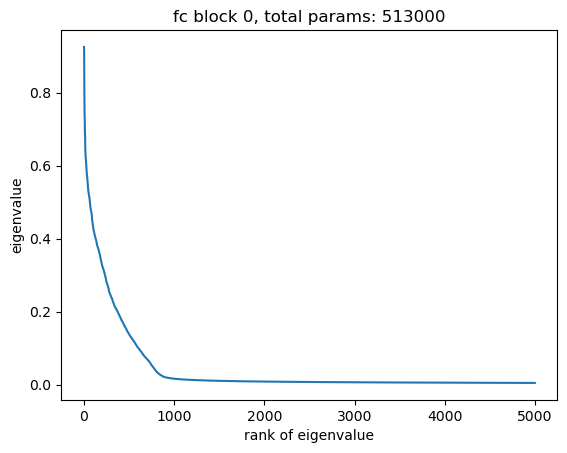

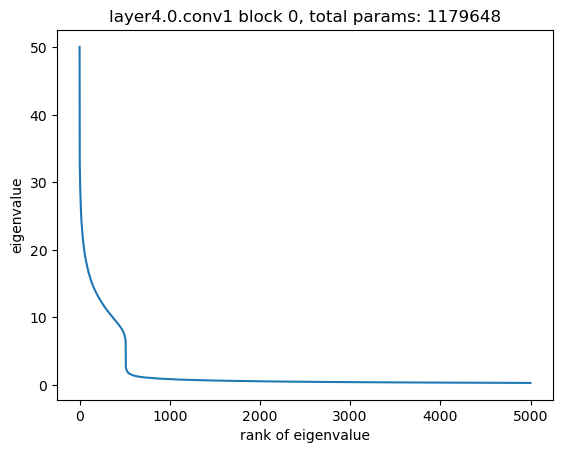

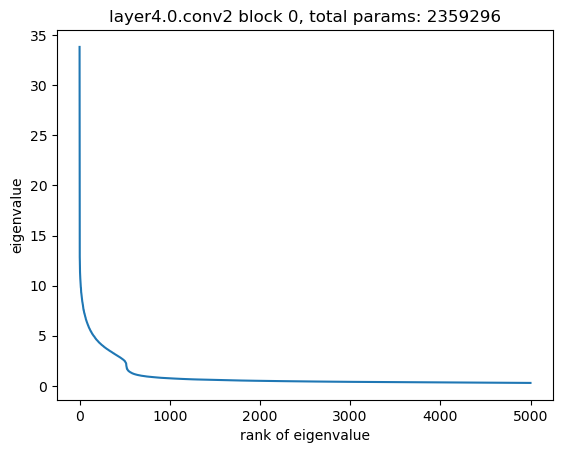

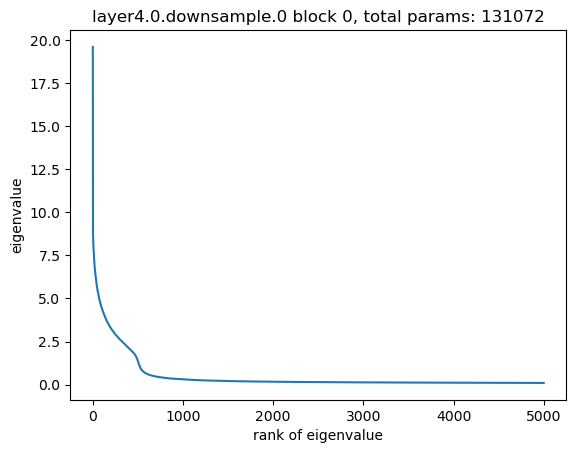

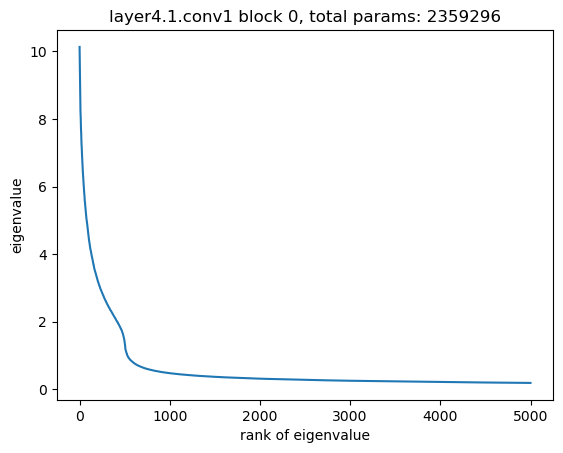

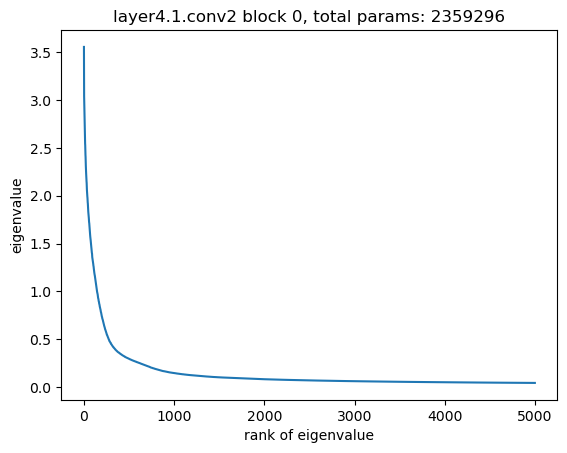

In [13]:
for (layer, layer_eigvals) in zip(layers, eigvals):
    for (k, layer_block_eigvals) in enumerate(layer_eigvals):
        num = 5000
        fig, ax = plt.subplots()
        _layer_block_eigvals = layer_block_eigvals[:num]
        ax.plot(list(range(len(_layer_block_eigvals))), _layer_block_eigvals)
        ax.set_xlabel('rank of eigenvalue')
        ax.set_ylabel('eigenvalue')
        ax.set_title(f"{layer} block {k}, total params: {len(layer_block_eigvals)}")
        fig.show()

### see if dataloader is deterministic

In [ ]:
print("trial 1:")
print(next(iter(eval_dataloader)))
print("trial 2:")
print(next(iter(eval_dataloader)))

### create arnoldi embedder to profile

In [7]:
from infembed.embedder._core.arnoldi_embedder import ArnoldiEmbedder

arnoldi_layers = [
    "fc",
    "layer4.0.conv1",
    "layer4.0.conv2",
    "layer4.0.downsample.0",
    "layer4.1.conv1",
    "layer4.1.conv2",
]

arnoldi_embedder = ArnoldiEmbedder(
    layers=arnoldi_layers,
    loss_fn=nn.CrossEntropyLoss(reduction='mean'),
    sample_wise_grads_per_batch=True,
    projection_dim=2,
    show_progress=True,
    model=model,
    arnoldi_dim=2,
)

### create smaller train dataloader for profiling

In [12]:
profile_train_data = Subset(_train_data, torch.randperm(len(_train_data))[:10])
profile_train_dataloader = DataLoader(
    train_data, collate_fn=collate_fn, batch_size=16, num_workers=0,
)

### profile arnoldi

In [11]:
%prun arnoldi_embedder.fit(profile_train_dataloader)

INFO:root:start arnoldi iteration
INFO:root:start `_parameter_arnoldi`
Running Arnoldi Iteration for step:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:arnoldi iteration step 1


Running Arnoldi Iteration for step: 100%|██████████| 2/2 [01:31<00:00, 45.91s/it]
INFO:root:start `_parameter_distill`


         6764929 function calls (6354596 primitive calls) in 91.863 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    25676   47.127    0.002   47.127    0.002 {method 'decode' of 'ImagingDecoder' objects}
     9996   21.508    0.002   21.508    0.002 {method 'resize' of 'ImagingCore' objects}
     1878    6.032    0.003    6.032    0.003 {method 'run_backward' of 'torch._C._EngineBase' objects}
    11296    1.833    0.000    1.833    0.000 {method 'to' of 'torch._C._TensorBase' objects}
     9806    1.408    0.000    1.408    0.000 {method 'copy' of 'ImagingCore' objects}
    12520    0.999    0.000    0.999    0.000 {built-in method torch.conv2d}
    10000    0.842    0.000    0.842    0.000 {method 'sub_' of 'torch._C._TensorBase' objects}
    10000    0.649    0.000    0.649    0.000 {method 'div_' of 'torch._C._TensorBase' objects}
    10000    0.633    0.000    0.633    0.000 {built-in method PIL._imaging.new}
     

#### see how slow just getting data is

In [14]:
for batch in tqdm(profile_train_dataloader):
    pass

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f51a80dea60>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/test2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/miniconda3/envs/test2/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/ubuntu/miniconda3/envs/test2/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/ubuntu/miniconda3/envs/test2/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/ubuntu/miniconda3/envs/test2/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/ubuntu/miniconda3/envs/test2/lib/python3.9/se

RuntimeError: cannot pin 'torch.cuda.FloatTensor' only dense CPU tensors can be pinned

> /home/ubuntu/miniconda3/envs/test2/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py(58)pin_memory()
     56 def pin_memory(data, device=None):
     57     if isinstance(data, torch.Tensor):
---> 58         return data.pin_memory(device)
     59     elif isinstance(data, (str, bytes)):
     60         return data



### compute embeddings for evaluation data ###
we then package them into a `Data` instance, which contains all kinds of data that could possibly be used to do the subsequent clustering, i.e. including tabular metadata as well.

In [8]:
embeddings = embedder.predict(eval_dataloader)
data = Data(embeddings=embeddings)

Using FastKFACEmbedder to compute influence embeddings. Processing batch:   0%|          | 0/157 [00:00<?, ?it…

### define clusterer ###

In [9]:
clusterer = SklearnClusterer(sklearn_clusterer=KMeans(n_clusters=10))

### do the clustering ###

In [13]:
clusters = clusterer.fit_predict(data)

### compute metadata for evaluation data ###
this will be the ingredient needed to display the clusters.  later on, it will also be used by the rule-based clusterer.  therefore, we also add it to the running `Data` instance for easy access.

In [14]:
def _get_predictions_and_labels(_model, dataloader):
    dfs = []
    for batch in tqdm(dataloader):
        prediction_prob = (
            torch.nn.functional.softmax(_model(*batch[:-1]), dim=1)
            .detach()
            .to(device="cpu")
        )
        prediction_label = torch.argmax(prediction_prob, dim=1).to(device="cpu")
        label = batch[-1].to(
            device="cpu"
        )  # assuming batch is a tensor.  if not, can check
        dfs.append(
            pd.DataFrame(
                {
                    "prediction_label": prediction_label,
                    "label": label,
                    "prediction_prob": list(prediction_prob.numpy()),
                }
            )
        )
    df = pd.concat(dfs, axis=0)
    df.index = list(range(len(df)))
    return df

metadata = _get_predictions_and_labels(model, eval_dataloader)
data.metadata = metadata

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:45<00:00,  3.48it/s]


### define ways to display clusters ###
these will all be functions whose input is a list of list of indices in the evaluation dataset

In [15]:
from infembed.visualization._core.common import PerClusterDisplayer, DisplayAccuracy

displayers = [
    PerClusterDisplayer([
        DisplayAccuracy(prediction_col='prediction_label', label_col='label')
    ])
]

### display the clusters ###

In [16]:
for displayer in displayers:
    displayer(clusters, data)

cluster #0
accuracy: 0.18 (55/307)
cluster #1
accuracy: 0.27 (7/26)
cluster #2
accuracy: 0.84 (3710/4426)
cluster #3
accuracy: 0.16 (6/37)
cluster #4
accuracy: 0.33 (13/39)
cluster #5
accuracy: 0.20 (13/66)
cluster #6
accuracy: 0.27 (11/41)
cluster #7
accuracy: 0.00 (0/1)
cluster #8
accuracy: 0.10 (3/29)
cluster #9
accuracy: 0.32 (9/28)


### define rule clusterer ###

In [42]:
def _accuracy(data):
    return (data.metadata["prediction_label"] == data.metadata["label"]).mean()


def _size(data):
    return len(data)


rule_clusterer = RuleClusterer(
    clusterer_getter=lambda n_clusters: SklearnClusterer(KMeans(n_clusters=n_clusters)),
    cluster_rule=lambda data: _accuracy(data) < 0.2,
    stopping_rule=lambda data: _size(data) < 50,
    max_depth=5,
    branching_factor=2,
)

### do the rule clustering ###

In [43]:
rule_clusters = rule_clusterer.fit_predict(data)

### display the rule clusters

In [40]:
for displayer in displayers:
    displayer(rule_clusters, data)

cluster #0
accuracy: 0.18 (60/328)
